# Checkbox Detection and Text Extraction Workflow

![Checkbox Detection and corresponding text extraction](images/checkbox_detection_workflow.png "Checkbox Detection and Text Extraction Workflow")

In [2]:
import easyocr
import cv2
from ultralytics import YOLO 

# Load OCR model into memory
reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

# Define constants
BOX_COLORS = {
    "unchecked": (242, 48, 48),
    "checked": (38, 115, 101),
    "block": (242, 159, 5)
}
BOX_PADDING = 2

# Load models
DETECTION_MODEL = YOLO("models/detector-model.pt") 


Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


## Helper function to detect checkboxes

In [3]:
def detect_checkbox(image_path):
    """
    Output inference image with bounding box
    Args:
    - image: to check for checkboxes
    Return: image with bounding boxes drawn 
    """
    image = cv2.imread(image_path)
    if image is None:
        return image
    
    # Predict on image
    results = DETECTION_MODEL.predict(source=image, conf=0.1, iou=0.8) # Predict on image
    boxes = results[0].boxes # Get bounding boxes

    if len(boxes) == 0:
        return image
    
    box_coordinates = []

    print('detection_class_conf', 'start_box', 'end_box')
    # Get bounding boxes
    for box in boxes:
        detection_class_conf = round(box.conf.item(), 2)
        detection_class = list(BOX_COLORS)[int(box.cls)]
        # Get start and end points of the current box
        start_box = (int(box.xyxy[0][0]), int(box.xyxy[0][1]))
        end_box = (int(box.xyxy[0][2]), int(box.xyxy[0][3]))
        box = image[start_box[1]:end_box[1], start_box[0]: end_box[0], :]
        
        if detection_class == 'checked':
            box_coordinates.append((start_box, end_box))
            
            # Display the start and end coordinates of bbox
            print(detection_class_conf, start_box, end_box)
            
            # 01. DRAW BOUNDING BOX OF OBJECT
            line_thickness = round(0.002 * (image.shape[0] + image.shape[1]) / 2) + 1
            image = cv2.rectangle(img=image, 
                                pt1=start_box, 
                                pt2=end_box,
                                color=BOX_COLORS['checked'], 
                                thickness = line_thickness) # Draw the box with predefined colors
            
            image = cv2.putText(img=image, org=start_box, text=detection_class, fontFace=0, color=(0,0,0), fontScale=line_thickness/3)

            # 02. DRAW LABEL
            text = str(detection_class_conf)
            # Get text dimensions to draw wrapping box
            font_thickness =  max(line_thickness - 1, 1)
            (text_w, text_h), _ = cv2.getTextSize(text=text, fontFace=2, fontScale=line_thickness/3, thickness=font_thickness)
            # Draw wrapping box for text
            image = cv2.rectangle(img=image,
                                  pt1=(start_box[0], start_box[1] - text_h - BOX_PADDING*2),
                                  pt2=(start_box[0] + text_w + BOX_PADDING * 2, start_box[1]),
                                  color=BOX_COLORS['checked'],
                                  thickness=-1)
            # Put class name on image
            start_text = (start_box[0] + BOX_PADDING, start_box[1] - BOX_PADDING)
            image = cv2.putText(img=image, text=text, org=start_text, fontFace=0, color=(255,255,255), fontScale=line_thickness/3, thickness=font_thickness)
        
    return image, box_coordinates

## Detect checkbox

Takes around ~ 3-6 seconds for each image

In [4]:
image_filename = f'images/sample.png'
checkbox_img, checkbox_coordinates = detect_checkbox(image_filename)


0: 640x544 5 uncheckeds, 7 checkeds, 820.2ms
Speed: 3.9ms preprocess, 820.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)
detection_class_conf start_box end_box
0.83 (520, 1162) (551, 1193)
0.83 (522, 1106) (553, 1137)
0.83 (522, 1052) (552, 1082)
0.79 (522, 998) (552, 1029)
0.64 (190, 1003) (212, 1024)
0.29 (186, 1281) (210, 1303)
0.14 (188, 1336) (207, 1355)


## Display detected checkbox

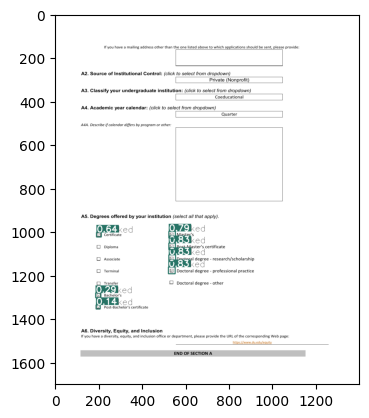

In [5]:
import matplotlib.pyplot as plt

plt.imshow(checkbox_img)

## EasyOCR to get the coordinates of the detected text

Extract all of the text from the given image along with their coordinates

It takes ~12 seconds for each image

In [6]:
# canvas_size = 1400
# image_filename = f'output/{pdf_filename}_output_{curr_image}.png'
# image_filename = f'output/{pdf_filename}_output_1.png'

# canvas_size = 1400, mag_ratio = 1.5, -> 1371
# canvas_size = 900, mag_ratio = 1.8  -> 3785

result = reader.readtext(image_filename, decoder = 'beamsearch',
                 text_threshold = 0.8, low_text = 0.2, link_threshold = 0.4,
                 canvas_size = 1500, mag_ratio = 1.5,
                 slope_ths = 0.1, ycenter_ths = 0.8, height_ths = 0.8,
                 width_ths = 1.0, y_ths = 0.8, x_ths = 1.0, add_margin = 0.1)

# for each in result:
#     print(each)

## Extract the coordinates of the CHECKED checkbox and all the texts detected in the given image

In [7]:
# Get the bottom right coordinates of the CHECKED checkbox
checkbox_bottom_right_coord = []

for each in checkbox_coordinates:
    checkbox_bottom_right_coord.append((each[1][0], each[0][1]))

# Sort based on the coordinates
checkbox_bottom_right_coord = sorted(checkbox_bottom_right_coord, key=lambda point: point[1])

print("The bottom right coordinate of all the CHECKED checkboxes")
print(checkbox_bottom_right_coord)


# Get the bottom left coordinate of all the detected text
print("\nThe bottom left coordinate of all the detected text")
detected_text = {}

for index, each in enumerate(result):
    x_coord = int(each[0][0][0])
    y_coord = int(each[0][0][1])
    detected_text[(x_coord, y_coord)] = each[1]

for k, v in detected_text.items():
    print(k, v)

The bottom right coordinate of all the CHECKED checkboxes
[(552, 998), (212, 1003), (552, 1052), (553, 1106), (551, 1162), (210, 1281), (207, 1336)]

The bottom left coordinate of all the detected text
(233, 137) you have a mailing address other than the one listed above to which applications should be sentplease provide:
(112, 257) A2. Source of Institutional Control: (click to select from dropdown)
(702, 288) Private (Nonprofit)
(114, 332) A3. Classify your undergraduate institution: (click to select
(788, 336) dropdown)
(730, 367) Coeducational
(115, 415) A4. Academic year calendar: (click to select from dropdown)
(759, 446) Quarter
(113, 494) A4A. Describe if calendar differs by program or other:
(114, 911) As. Degrees offered by your institution (select all that apply).
(220, 999) Certificate
(553, 999) Master's
(220, 1056) Diploma
(553, 1054) Post-Master's certificate
(220, 1113) Associate
(552, 1109) Doctoral degree - research/scholarship
(220, 1167) Terminal
(552, 1162) Doctora

## Helper function to calculate Euclidean distance between two coordinates

In [8]:
import math

def euclidean_distance(coord1, coord2):
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

def nearest_coordinate(target_coord, coordinates):
    min_distance = float('inf')
    nearest_coord = None
    
    for coord in coordinates:
        distance = euclidean_distance(target_coord, coord)
        if distance < min_distance:
            min_distance = distance
            nearest_coord = coord
    
    
    return nearest_coord, euclidean_distance(target_coord, nearest_coord)

## Extract the text corresponding to the CHECKED checkboxes based on the Euclidean distance

<img src="images/detected_checkbox_coordinates.png" width="500">

In [9]:
# TODO Text cleanup, lowercase to match with the desired word_list for a particular section

for each_checkbox_coord in checkbox_bottom_right_coord:
    nearest, distance = nearest_coordinate(each_checkbox_coord, list(detected_text.keys()))
    if distance <= 15:
        print(detected_text[nearest])
        


Master's
Certificate
Post-Master's certificate
Doctoral degree - research/scholarship
Doctoral degree - professional practice
Bachelor's
Post-Bachelor's certificate
